<a href="https://colab.research.google.com/github/pimentad2020/DSWP/blob/master/Notebooks/NB10_04__3DP_4_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b><i>3DP_4 - ANOMALY/OUTLIER DETECTION</i></b></h1></center>



# **AGENDA**:

> Consulte a **Table of contents**.

# **Melhorias da sessão**
* Mostrar junto os gráficos com a região de Anomaly Score junto com a distribuição de probabilidade das variáveis envolvidas.
* Mensagens de deprecating --> Analisar e substituir os métodos, funções deprecated;


___
# **Referências**
* [Comparing anomaly detection algorithms for outlier detection on toy datasets](https://scikit-learn.org/stable/auto_examples/plot_anomaly_comparison.html#sphx-glr-auto-examples-plot-anomaly-comparison-py)
* [Outlier detection with several methods](https://scikit-learn.org/0.18/auto_examples/covariance/plot_outlier_detection.html)
* [anomaly-detection-resources](https://github.com/MathMachado/anomaly-detection-resources)
* [Outlier Detection with Extended Isolation Forest](https://towardsdatascience.com/outlier-detection-with-extended-isolation-forest-1e248a3fe97b)
* [Outlier Detection with Isolation Forest](https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e).

___
## O que é Anomaly Detection (= Análise de Outliers)?
> Qualquer ponto/observação que é incomum quando comparado com todos os outros pontos/observações.

___
# **Machine Learning com Python (Scikit-Learn)**

![Scikit-Learn](https://github.com/MathMachado/Materials/blob/master/scikit-learn-1.png?raw=true)

___
# **Técnicas tradicionais para detecção de outliers**

## Boxplot
* $IQR = Q_{3}-Q_{1}$

![BoxPlot](https://github.com/MathMachado/Materials/blob/master/boxplot.png?raw=true)

## Z-Score
* Z-Score pode ser utilizado para detectar Outliers.
* É a diferença entre o valor e a média da amostra expressa como o número de desvios-padrão. 
* Se o escore z for menor que 2,5 ou maior que 2,5, o valor estará nos 5% do menor ou maior valor (2,5% dos valores em ambas as extremidades da distribuição). No entanto, é pratica comum utilizarmos 3 ao invés dos 2,5.

![Z_Score](https://github.com/MathMachado/Materials/blob/master/Z_Score.png?raw=true)

___
# **Hands-On**

## Carrega as Bibliotecas necessárias

In [47]:
!pip install pyod

In [87]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.ensemble import IsolationForest

# Scaling variables - Transformações
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Libraries interessantes para detecção de Outliers: ABOD  CBLOF   HBOS IForest

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF

#from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
#from pyod.models.lof import LOF
from scipy import stats

# recomendado não habilitar estas opções
# remove warnings to keep notebook clean
import warnings
warnings.filterwarnings('ignore')

## Carrega dataframe

In [65]:
df_titanic = sns.load_dataset('titanic')
df_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.000,1,0,7.250,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.000,1,0,71.283,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.000,0,0,7.925,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.000,1,0,53.100,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.000,0,0,8.050,S,Third,man,True,NaN,Southampton,no,True


In [66]:
df_titanic.isna()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
887,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
888,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False
889,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [67]:
df_titanic.isna().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [60]:
# Por simplicidade, vou descartando/omitindo todos os Missing Values
df_titanic = df_titanic.dropna() # Esta não é a forma adequada! Dê o devido tratamento aos Missing Values (NaN) da base de dados!
df_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
1,1,1,female,38.000,1,0,71.283,C,First,woman,False,C,Cherbourg,yes,False
3,1,1,female,35.000,1,0,53.100,S,First,woman,False,C,Southampton,yes,False
6,0,1,male,54.000,0,0,51.862,S,First,man,True,E,Southampton,no,True
10,1,3,female,4.000,1,1,16.700,S,Third,child,False,G,Southampton,yes,False
11,1,1,female,58.000,0,0,26.550,S,First,woman,False,C,Southampton,yes,True


In [61]:
# Normalizar as variáveis 'age' e 'fare'
df_titanic_ss = df_titanic.copy()
df_titanic_ss[['fare', 'age']] = StandardScaler().fit_transform(df_titanic_ss[['fare', 'age']])

In [62]:
# Linhas do df_titanic
df_titanic_ss.shape

(182, 15)

In [63]:
# Função para plotar o Boxplot
def boxplot_sobreviveu(df, column):
    plt.rcdefaults()
    sns.catplot(x = 'survived', y = column, kind = "box", data = df, height = 4, aspect = 1.5)
    
    # add data points to boxplot with stripplot
    sns.stripplot(x = 'survived', y = column, data = df, alpha = 0.3, jitter = 0.2, color = 'k');
    plt.show()

Esta é a visão univariada da variável 'fare':

In [56]:
df_titanic[['survived']].head()

,survived
1,1
3,1
6,0
10,1
11,1


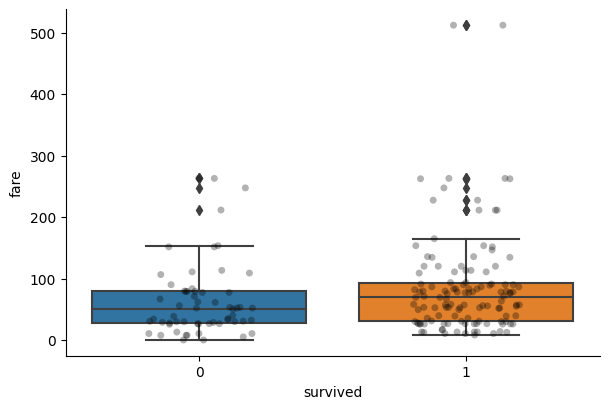

In [57]:
boxplot_sobreviveu(df_titanic, 'fare')
# 3 pessoas pagaram 500 dolares (fare) e sobreviveram survived = 1
# cruzando Y (target) com x = fare (qto pagou)
# média de sobreviventes pagou mais (média do boxplot y =1)

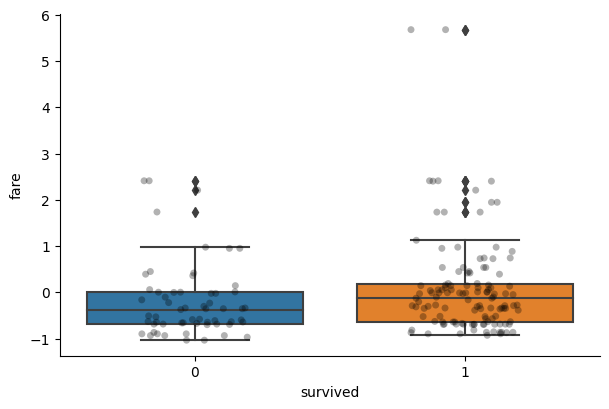

In [58]:
boxplot_sobreviveu(df_titanic_ss, 'fare')

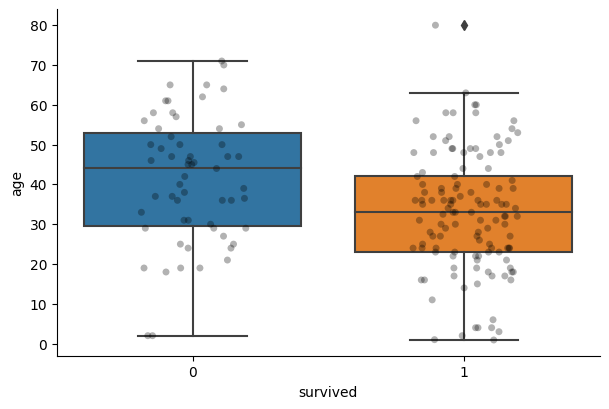

In [12]:
boxplot_sobreviveu(df_titanic, 'age')
# mais velhos não sobreviveram (boxplot azul média mais alta)

In [70]:
# Descrever o dataframe, variável 'fare'
pd.set_option('display.float_format', lambda x: '%.3f' %x)
df_titanic_ss['fare'].describe()

count   182.000
mean      0.000
std       1.003
min      -1.035
25%      -0.645
50%      -0.287
75%       0.145
max       5.682
Name: fare, dtype: float64

## Mostrar a frequência acumulada!! É mais informativo!!!

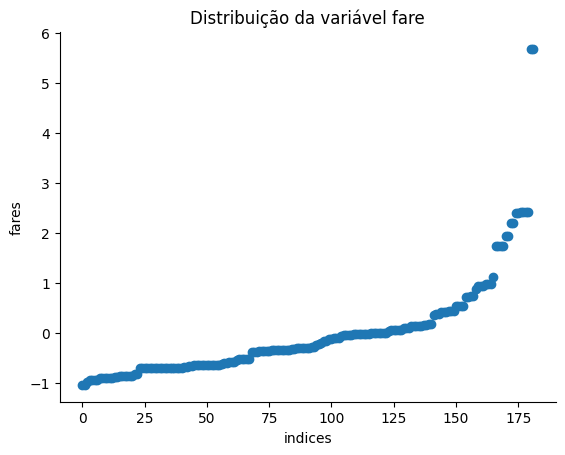

In [71]:
plt.scatter(range(df_titanic_ss.shape[0]), np.sort(df_titanic_ss['fare'].values)) 
# fare está plotado em z_score 
# A intenção do gráfico é ordenar os valores em df_titanic['fare'] do menor valor para o maior!
plt.xlabel('indices')
plt.ylabel('fares')
plt.title("Distribuição da variável fare")

sns.despine()

In [72]:
df_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.000,1,0,7.250,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.000,1,0,71.283,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.000,0,0,7.925,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.000,1,0,53.100,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.000,0,0,8.050,S,Third,man,True,NaN,Southampton,no,True


In [73]:
df_titanic_ss.describe()

,survived,pclass,age,sibsp,parch,fare
count,182.000,182.000,182.000,182.000,182.000,182.000
mean,0.676,1.192,0.000,0.467,0.478,0.000
std,0.469,0.516,1.003,0.645,0.756,1.003
min,0.000,1.000,-2.221,0.000,0.000,-1.035
25%,0.000,1.000,-0.744,0.000,0.000,-0.645
50%,1.000,1.000,0.024,0.000,0.000,-0.287
75%,1.000,1.000,0.776,1.000,1.000,0.145
max,1.000,3.000,2.839,3.000,4.000,5.682


Com o gráfico acima, podemos ver quais e quantos são os pontos que estão acima de $\mu + 3\sigma$ --> Se usarmos o critério do z-score, todos os pontos acima deste limiar são outliers!

 Colocar os gráficos lado a lado: df_titanic e df_titanic_ss!!

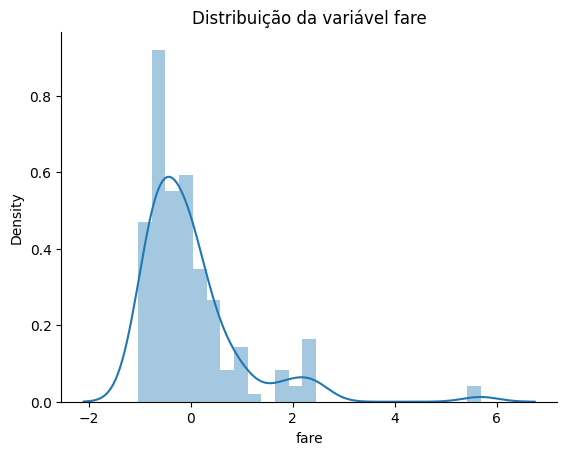

In [69]:
# Distribuição da variável 'fare' (após StandardScaler) df_titanic_ss
sns.distplot(df_titanic_ss['fare'])
plt.title("Distribuição da variável fare")
sns.despine()

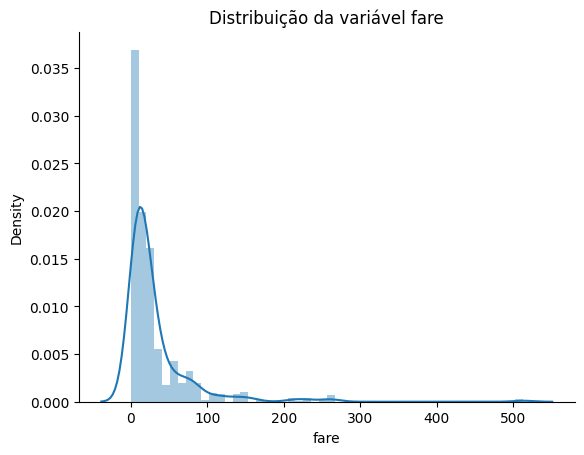

In [75]:
# Distribuição da variável 'fare' (antes do StandardScaler)  z = (x - media) / dp
# df_titanic
sns.distplot(df_titanic['fare'])
plt.title("Distribuição da variável fare")
sns.despine()

### Calcular a mediana e comparar com a média.

In [74]:
df_titanic.describe()  # antes do StandScaler
# min = 0 os trabalhadores não pagaram a passagem

,survived,pclass,age,sibsp,parch,fare
count,891.000,891.000,714.000,891.000,891.000,891.000
mean,0.384,2.309,29.699,0.523,0.382,32.204
std,0.487,0.836,14.526,1.103,0.806,49.693
min,0.000,1.000,0.420,0.000,0.000,0.000
25%,0.000,2.000,20.125,0.000,0.000,7.910
50%,0.000,3.000,28.000,0.000,0.000,14.454
75%,1.000,3.000,38.000,1.000,0.000,31.000
max,1.000,3.000,80.000,8.000,6.000,512.329


___
## Kurtosis
> Kurtosis é uma medida estatística que define com que intensidade as caudas de uma distribuição diferem das caudas de uma distribuição Normal. Em outras palavras, a curtose identifica se as caudas de uma determinada distribuição contêm valores extremos.
>> A Kurtosis de uma distribuição Normal padrão é igual a 3. Portanto, se Kurtosis-3 > 0, então isso é o que chamamos de excesso de Kurtosis.
>>> **Alta Kurtosis é um indicador de que os dados possuem caudas pesadas ou outliers**.

* **Dica muito importante**: Normalize os dados antes!

___
## Skewness
> É o grau de distorção da distribuição, ou seja, mede a falta de simetria na distribuição de dados, diferenciando valores extremos em uma cauda versus na outra. Uma distribuição simétrica terá uma assimetria de 0.

![Skewness](https://github.com/MathMachado/Materials/blob/master/Skewness.png?raw=true)

Source: [Skew and Kurtosis: 2 Important Statistics terms you need to know in Data Science](https://codeburst.io/2-important-statistics-terms-you-need-to-know-in-data-science-skewness-and-kurtosis-388fef94eeaa)

### Interpretando a Skewness (Rule of Thumb)
* Se -0.5 < Skewness < 0.5: Dados razoavelmente simétricos;
* Se -1 < Skewness < -0.5: Dados moderadamente negativa;
* Se 0.5 < Skewness < 1: Dados moderadamente positiva;
* Se Skewness < -1: Dados altamente negativa;
* Se Skewness > 1: Dados altamente positiva.

> **Dica**: Normalize os dados antes!

* comparar posição da moda e da mediana e comparar

In [76]:
# Cálculo das medidas de Skewness e Kurtosis para 'fare'
print(f"Skewness: {df_titanic_ss['fare'].skew()}")
print(f"Kurtosis: {df_titanic_ss['fare'].kurt()}")

Skewness: 2.7073683146429004
Kurtosis: 10.690697893681472


Olhando para as medidas de Skewness e Kurtosis logo acima, qual a conclusão?

In [77]:
# Distribuição da variável 'age'
df_titanic_ss['age'].describe()

count   182.000
mean      0.000
std       1.003
min      -2.221
25%      -0.744
50%       0.024
75%       0.776
max       2.839
Name: age, dtype: float64

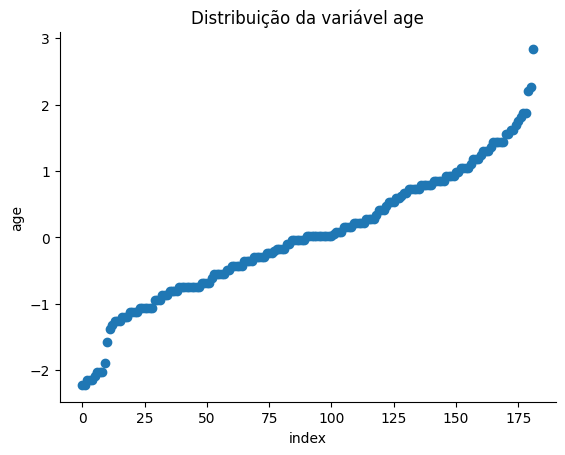

In [78]:
plt.scatter(range(df_titanic_ss.shape[0]), np.sort(df_titanic_ss['age'].values))
plt.xlabel('index')
plt.ylabel('age')
plt.title("Distribuição da variável age")
sns.despine()

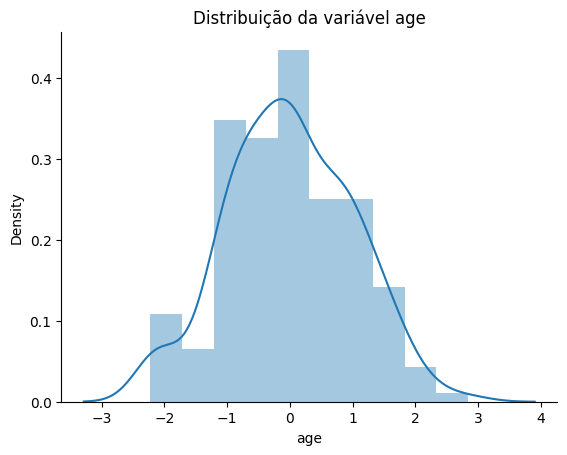

In [79]:
sns.distplot(df_titanic_ss['age'])  # age padronizada StandScaler
plt.title("Distribuição da variável age")
sns.despine()

In [80]:
# Cálculo das medidas de Skewness e Kurtosis para 'age'
print(f"Skewness: {df_titanic_ss['age'].skew()}")
print(f"Kurtosis: {df_titanic_ss['age'].kurt()}")

Skewness: 0.01841894050949496
Kurtosis: -0.2309427735598728


Olhando para as medidas de Skewness e Kurtosis logo acima, qual a conclusão?

___
## **CBLOF - Cluster-based Local Outlier Factor**

In [81]:
df_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.000,1,0,7.250,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.000,1,0,71.283,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.000,0,0,7.925,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.000,1,0,53.100,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.000,0,0,8.050,S,Third,man,True,NaN,Southampton,no,True


In [82]:
# Normalizar as variáveis 'age' e 'fare'
df_titanic_ss = df_titanic.copy()
df_titanic_ss[['fare', 'age']] = MinMaxScaler().fit_transform(df_titanic_ss[['fare', 'age']])

In [83]:
X1 = df_titanic_ss['age'].values.reshape(-1, 1)
X2 = df_titanic_ss['fare'].values.reshape(-1, 1)
X = np.concatenate((X1,X2), axis = 1)

In [85]:
X

array([[0.27117366, 0.01415106],
       [0.4722292 , 0.13913574],
       [0.32143755, 0.01546857],
       ...,
       [       nan, 0.04577135],
       [0.32143755, 0.0585561 ],
       [0.39683338, 0.01512699]])

In [86]:
type(X)

numpy.ndarray

In [84]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))

clf = CBLOF(contamination = outliers_fraction, check_estimator = False, random_state = 0)
clf.fit(X)

# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)

plt.figure(figsize = (8, 8))

df1 = df_titanic_ss
df1['outlier'] = y_pred.tolist()

inliers_fare = np.array(df1['fare'][df1['outlier'] == 0]).reshape(-1,1)
inliers_age = np.array(df1['age'][df1['outlier'] == 0]).reshape(-1,1)
    
outliers_fare = df1['fare'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_age = df1['age'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
        
# Use threshold para definir um ponto como inlier ou outlier
# threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# Calcula o Anomaly Score
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 7), cmap = plt.cm.Blues_r)
        
# Desenha a linha vermelha a partir do qual Anomaly Score = thresold
a = plt.contour(xx, yy, Z, levels = [threshold], linewidths = 2, colors = 'red')
        
# Região Azul onde threshold < Anomaly Score < max(Anomaly score)
plt.contourf(xx, yy, Z, levels= [threshold, Z.max()], colors='orange')
b = plt.scatter(inliers_fare, inliers_age, c = 'white', s = 20, edgecolor = 'k')
    
c = plt.scatter(outliers_fare, outliers_age, c = 'black', s = 20, edgecolor = 'k')
       
plt.axis('tight')   
plt.legend([a.collections[0], b, c], ['learned decision function', 'inliers', 'outliers'],
           prop = matplotlib.font_manager.FontProperties(size = 10), loc = 'upper center', frameon = False, bbox_to_anchor = (0.5, -0.05),
          fancybox = True, shadow = True, ncol = 5)
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Cluster-based Local Outlier Factor (CBLOF)')
plt.show()

ValueError: ignored

In [27]:
# Zoom em alguns outliers...
df1.loc[df1['outlier'] == 1].head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,outlier
679,1,1,male,0.444,0,1,1.000,C,First,man,True,B,Cherbourg,yes,False,1
737,1,1,male,0.431,0,0,1.000,C,First,man,True,B,Cherbourg,yes,True,1


### Dados originais (sem a transformação MinMaxScaler())
* Qual a idade e os valores pagos pelos Outliers?

In [28]:
df_titanic[['age', 'fare']].loc[679]

age     36.000
fare   512.329
Name: 679, dtype: float64

In [29]:
df_titanic[['age', 'fare']].loc[737]

age     35.000
fare   512.329
Name: 737, dtype: float64

### Questões interessantes: Age vs Fare
* Qual a idade e valor médio pago pelos passageiros que não sobreviveram?

In [30]:
# Algumas medidas para compararmos
df_resumo = df_titanic.groupby(['survived', 'sex']).agg({'age': ['mean'], 'fare': ['mean']}).round(0)
df_resumo

age   fare
                  mean   mean
survived sex                 
0        female 28.000 61.000
         male   43.000 65.000
1        female 33.000 91.000
         male   33.000 75.000

In [31]:
df_titanic['age_cat'] = pd.cut(df_titanic['age'], bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
df_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,age_cat
1,1,1,female,38.000,1,0,71.283,C,First,woman,False,C,Cherbourg,yes,False,"(30, 40]"
3,1,1,female,35.000,1,0,53.100,S,First,woman,False,C,Southampton,yes,False,"(30, 40]"
6,0,1,male,54.000,0,0,51.862,S,First,man,True,E,Southampton,no,True,"(50, 60]"
10,1,3,female,4.000,1,1,16.700,S,Third,child,False,G,Southampton,yes,False,"(0, 10]"
11,1,1,female,58.000,0,0,26.550,S,First,woman,False,C,Southampton,yes,True,"(50, 60]"


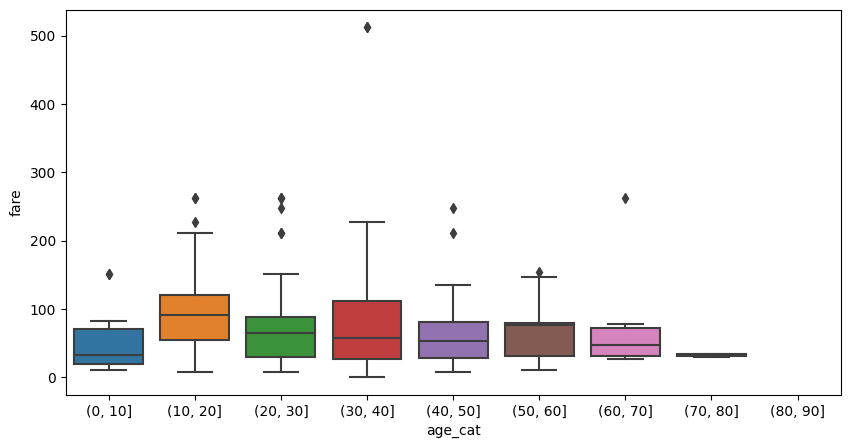

In [32]:
plt.figure(figsize = (10, 5))
sns.boxplot(x = 'age_cat', y = 'fare', data = df_titanic)

In [33]:
# Algumas medidas para compararmos
df_resumo = df_titanic.groupby(['survived', 'sex', 'age_cat']).agg({'age': ['mean'], 'fare': ['mean']}).round(0)
df_resumo

age    fare
                           mean    mean
survived sex    age_cat                
0        female (0, 10]   2.000  81.000
                (10, 20]    nan     nan
                (20, 30] 27.000  81.000
                (30, 40]    nan     nan
                (40, 50] 50.000  29.000
                (50, 60] 57.000  10.000
                (60, 70]    nan     nan
                (70, 80]    nan     nan
                (80, 90]    nan     nan
         male   (0, 10]     nan     nan
                (10, 20] 19.000 108.000
                (20, 30] 26.000  93.000
                (30, 40] 36.000  42.000
                (40, 50] 46.000  57.000
                (50, 60] 55.000  59.000
                (60, 70] 64.000  74.000
                (70, 80] 71.000  35.000
                (80, 90]    nan     nan
1        female (0, 10]   4.000  28.000
                (10, 20] 17.000 108.000
                (20, 30] 25.000  89.000
                (30, 40] 36.000  93.000
                (40, 50] 46.000  90.000
                (50, 60] 55.000  86.000
                (60, 70] 63.000  78.000
                (70, 80]    nan     nan
                (80, 90]    nan     nan
         male   (0, 10]   3.000  56.000
                (10, 20] 14.000 115.000
                (20, 30] 26.000  54.000
                (30, 40] 35.000 116.000
                (40, 50] 47.000  54.000
                (50, 60] 55.000  43.000
                (60, 70]    nan     nan
                (70, 80] 80.000  30.000
                (80, 90]    nan     nan

___
## **HBOS - Histogram-based Outlier Detection**

OUTLIERS: 2 INLIERS: 180


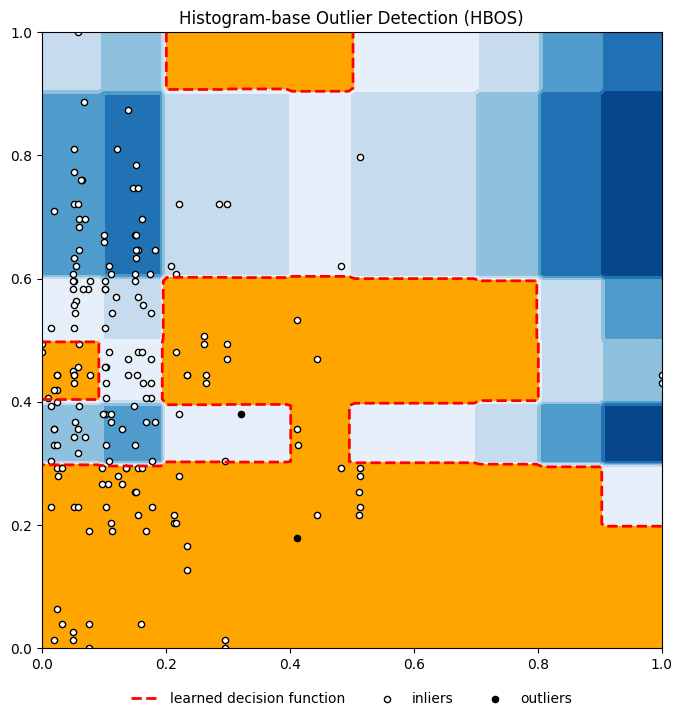

In [34]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = HBOS(contamination = outliers_fraction)
clf.fit(X)

# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize = (8, 8))

# copy of dataframe
df1 = df_titanic_ss
df1['outlier'] = y_pred.tolist()
    
inliers_fare = np.array(df1['fare'][df1['outlier'] == 0]).reshape(-1, 1)
inliers_age = np.array(df1['age'][df1['outlier'] == 0]).reshape(-1, 1)
    
outliers_fare = df1['fare'][df1['outlier'] == 1].values.reshape(-1, 1)
outliers_age = df1['age'][df1['outlier'] == 1].values.reshape(-1, 1)
         
print('OUTLIERS:', n_outliers, 'INLIERS:', n_inliers)
        
# threshold define se um ponto será outlier ou inlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# Calcula o Anomaly score
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

# Define a região azul tal que min(Anomaly score) < threshold
plt.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 7), cmap = plt.cm.Blues_r)
        
# Desenha a linha a partir do queal Anomaly score = thresold
a = plt.contour(xx, yy, Z, levels = [threshold], linewidths = 2, colors = 'red')
        
# Define a região laranja a partir do qual threshold < Anomaly score < max(Anomaly score)
plt.contourf(xx, yy, Z, levels = [threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_fare, inliers_age, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_fare, outliers_age, c='black',s=20, edgecolor='k')
       
plt.axis('tight')  
     
plt.legend([a.collections[0], b, c], ['learned decision function', 'inliers', 'outliers'],
           prop=matplotlib.font_manager.FontProperties(size = 10), loc ='upper center', frameon = False, bbox_to_anchor = (0.5, -0.05),
          fancybox = True, shadow = True, ncol = 5)
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Histogram-base Outlier Detection (HBOS)')
plt.show();

In [35]:
# Zoom em alguns outliers...
df1.loc[df1['outlier'] == 1].head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,outlier
318,1,1,female,0.380,0,2,0.322,S,First,woman,False,C,Southampton,yes,False,1
689,1,1,female,0.178,0,1,0.413,S,First,child,False,B,Southampton,yes,False,1


In [36]:
# Zoom na linha 689
df_titanic[['age', 'fare', 'survived']].loc[689]

age         15.000
fare       211.338
survived     1.000
Name: 689, dtype: float64

In [37]:
# Algumas medidas para compararmos
df_resumo = df_titanic.groupby(['sex', 'survived']).agg({'age': ['mean'], 'fare': ['mean']}).round(0)
df_resumo

age   fare
                  mean   mean
sex    survived              
female 0        28.000 61.000
       1        33.000 91.000
male   0        43.000 65.000
       1        33.000 75.000

In [38]:
# Zoom na linha 318
df_titanic[['age', 'fare', 'survived']].loc[318]

age         31.000
fare       164.867
survived     1.000
Name: 318, dtype: float64

___
## **Isolation Forest**

* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

* https://www.kaggle.com/rgaddati/unsupervised-fraud-detection-isolation-forest

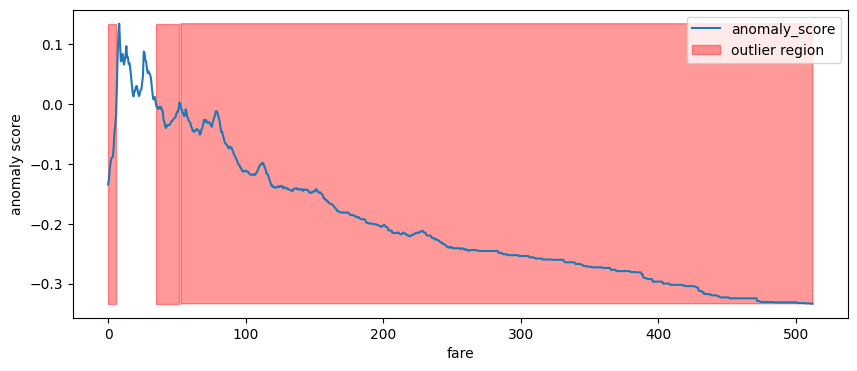

In [91]:
# Instanciar 
# é um algortimo que aponta anomalias nos dados (anomaly detection)
isolation_forest = IsolationForest(n_estimators=100)

# Ajustamento fit()
isolation_forest.fit(df_titanic['fare'].values.reshape(-1,1))
xx = np.linspace(df_titanic['fare'].min(), df_titanic['fare'].max(),len(df_titanic)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)

plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly_score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), where = outlier == -1, color = 'r', alpha = 0.4, label = 'outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('fare')
plt.show()

In [ ]:
# Conclusão: acima de 30 (aprox) passa a ser outlier 
# traçar uma linha horizontal em anomaly_score = 0.0 para visualizar
# anomaly_score > 0 não é outlier (na faixa branca antes da região salmão)
# do contrário, anomaly_score < 0 é outlier

In [92]:
df_titanic.loc[df_titanic['fare']>200].head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
27,0,1,male,19.000,3,2,263.000,S,First,man,True,C,Southampton,no,False
88,1,1,female,23.000,3,2,263.000,S,First,woman,False,C,Southampton,yes,False
118,0,1,male,24.000,0,1,247.521,C,First,man,True,B,Cherbourg,no,False
258,1,1,female,35.000,0,0,512.329,C,First,woman,False,NaN,Cherbourg,yes,True
299,1,1,female,50.000,0,1,247.521,C,First,woman,False,B,Cherbourg,yes,False


In [93]:
df_titanic.loc[27]  # Zoom na linha 27

survived                 0
pclass                   1
sex                   male
age                 19.000
sibsp                    3
parch                    2
fare               263.000
embarked                 S
class                First
who                    man
adult_male            True
deck                     C
embark_town    Southampton
alive                   no
alone                False
Name: 27, dtype: object

In [ ]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = IForest(contamination = outliers_fraction,random_state = 0)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize = (8, 8))
# copy of dataframe
df1 = df_titanic_ss
df1['outlier'] = y_pred.tolist()
    
# fare - inlier feature 1,  age - inlier feature 2
inliers_fare = np.array(df1['fare'][df1['outlier'] == 0]).reshape(-1,1)
inliers_age = np.array(df1['age'][df1['outlier'] == 0]).reshape(-1,1)
    
# fare - outlier feature 1, age - outlier feature 2
outliers_fare = df1['fare'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_age = df1['age'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS: ', n_outliers,'INLIERS: ', n_inliers)
        
# threshold value to consider a datapoint inlier or outlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels= [threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels= [threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_fare, inliers_age, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_fare, outliers_age, c='black',s=20, edgecolor='k')
       
plt.axis('tight')
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers', 'outliers'],
           prop=matplotlib.font_manager.FontProperties(size = 10), loc='upper center', frameon= False, bbox_to_anchor = (0.5, -0.05),
          fancybox = True, shadow = True, ncol=5)
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Isolation Forest')
plt.show();

In [40]:
# Zoom em alguns outliers...
df1.loc[df1['outlier'] == 1].head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,outlier
679,1,1,male,0.444,0,1,1.000,C,First,man,True,B,Cherbourg,yes,False,1
737,1,1,male,0.431,0,0,1.000,C,First,man,True,B,Cherbourg,yes,True,1


São os mesmos pontos/observações apontadas pelo CBLOF.

___
## **KNN - K-Nearest Neighbors**

OUTLIERS:  2 INLIERS:  180


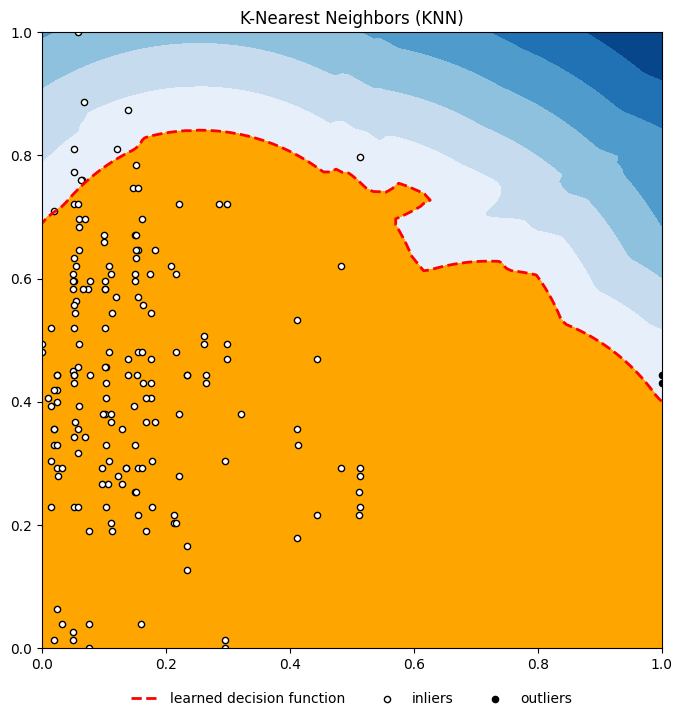

In [41]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = KNN(contamination = outliers_fraction)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize = (8, 8))
# copy of dataframe
df1 = df_titanic_ss
df1['outlier'] = y_pred.tolist()
    
inliers_fare = np.array(df1['fare'][df1['outlier'] == 0]).reshape(-1,1)
inliers_age = np.array(df1['age'][df1['outlier'] == 0]).reshape(-1,1)
    
outliers_fare = df1['fare'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_age = df1['age'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS: ',n_outliers, 'INLIERS: ', n_inliers)
        
# threshold value to consider a datapoint inlier or outlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels= [threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels= [threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_fare, inliers_age, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_fare, outliers_age, c='black',s=20, edgecolor='k')
       
plt.axis('tight')  
   
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers', 'outliers'],
           prop=matplotlib.font_manager.FontProperties(size=10), loc='upper center', frameon= False, bbox_to_anchor = (0.5, -0.05),
          fancybox = True, shadow = True, ncol = 5)
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('K-Nearest Neighbors (KNN)')
plt.show();

In [42]:
# Zoom em alguns outliers...
df1.loc[df1['outlier'] == 1].head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,outlier
679,1,1,male,0.444,0,1,1.000,C,First,man,True,B,Cherbourg,yes,False,1
737,1,1,male,0.431,0,0,1.000,C,First,man,True,B,Cherbourg,yes,True,1


São os mesmos pontos/observações apontadas pelo CBLOF.

___
# **Exercícios**
Para cada um dos dataframes a seguir, faça uma análise de outlier utilizando uma das técnicas apresentadas e explique seus resultados.

## Exercício 1 - Predict Breast Cancer

In [43]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X = cancer['data']
y = cancer['target']

df_cancer = pd.DataFrame(np.c_[X, y], columns= np.append(cancer['feature_names'], ['target']))
df_cancer['target'] = df_cancer['target'].map({0: 'malign', 1: 'benign'})
df_cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.990,10.380,122.800,1001.000,0.118,0.278,0.300,0.147,0.242,0.079,1.095,0.905,8.589,153.400,0.006,0.049,0.054,0.016,0.030,0.006,25.380,17.330,184.600,2019.000,0.162,0.666,0.712,0.265,0.460,0.119,malign
1,20.570,17.770,132.900,1326.000,0.085,0.079,0.087,0.070,0.181,0.057,0.543,0.734,3.398,74.080,0.005,0.013,0.019,0.013,0.014,0.004,24.990,23.410,158.800,1956.000,0.124,0.187,0.242,0.186,0.275,0.089,malign
2,19.690,21.250,130.000,1203.000,0.110,0.160,0.197,0.128,0.207,0.060,0.746,0.787,4.585,94.030,0.006,0.040,0.038,0.021,0.022,0.005,23.570,25.530,152.500,1709.000,0.144,0.424,0.450,0.243,0.361,0.088,malign
3,11.420,20.380,77.580,386.100,0.142,0.284,0.241,0.105,0.260,0.097,0.496,1.156,3.445,27.230,0.009,0.075,0.057,0.019,0.060,0.009,14.910,26.500,98.870,567.700,0.210,0.866,0.687,0.258,0.664,0.173,malign
4,20.290,14.340,135.100,1297.000,0.100,0.133,0.198,0.104,0.181,0.059,0.757,0.781,5.438,94.440,0.011,0.025,0.057,0.019,0.018,0.005,22.540,16.670,152.200,1575.000,0.137,0.205,0.400,0.163,0.236,0.077,malign


## Exercício 2 - Boston Housing Price

In [44]:
from sklearn.datasets import load_boston

boston = load_boston()
X = boston['data']
y = boston['target']

df_boston = pd.DataFrame(np.c_[X, y], columns = np.append(boston['feature_names'], ['target']))
df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.006,18.000,2.310,0.000,0.538,6.575,65.200,4.090,1.000,296.000,15.300,396.900,4.980,24.000
1,0.027,0.000,7.070,0.000,0.469,6.421,78.900,4.967,2.000,242.000,17.800,396.900,9.140,21.600
2,0.027,0.000,7.070,0.000,0.469,7.185,61.100,4.967,2.000,242.000,17.800,392.830,4.030,34.700
3,0.032,0.000,2.180,0.000,0.458,6.998,45.800,6.062,3.000,222.000,18.700,394.630,2.940,33.400
4,0.069,0.000,2.180,0.000,0.458,7.147,54.200,6.062,3.000,222.000,18.700,396.900,5.330,36.200


## Exercício 3 - Iris
* [Aqui](https://en.wikipedia.org/wiki/Iris_flower_data_set) você obterá mais informações sobre o dataframe iris.

In [45]:
from sklearn.datasets import load_iris

iris = load_iris()
X= iris['data']
y= iris['target']

df_iris = pd.DataFrame(np.c_[X, y], columns = np.append(iris['feature_names'], ['target']))
df_iris['target'] = df_iris['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.100,3.500,1.400,0.200,setosa
1,4.900,3.000,1.400,0.200,setosa
2,4.700,3.200,1.300,0.200,setosa
3,4.600,3.100,1.500,0.200,setosa
4,5.000,3.600,1.400,0.200,setosa


## Exercícios 4 - Diabetes

In [46]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
X = diabetes['data']
y = diabetes['target']

df_diabetes = pd.DataFrame(np.c_[X, y], columns = np.append(diabetes['feature_names'], ['target']))
df_diabetes.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038,0.051,0.062,0.022,-0.044,-0.035,-0.043,-0.003,0.020,-0.018,151.000
1,-0.002,-0.045,-0.051,-0.026,-0.008,-0.019,0.074,-0.039,-0.068,-0.092,75.000
2,0.085,0.051,0.044,-0.006,-0.046,-0.034,-0.032,-0.003,0.003,-0.026,141.000
3,-0.089,-0.045,-0.012,-0.037,0.012,0.025,-0.036,0.034,0.023,-0.009,206.000
4,0.005,-0.045,-0.036,0.022,0.004,0.016,0.008,-0.003,-0.032,-0.047,135.000
